In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

In [46]:
np.random.seed(42)

KMeans - Unbalanced Dataset

In [47]:
# 1. Load and prepare data
df = pd.read_csv("../Datasets/Unbalanced_Multiclass.csv")
df.tail()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
512,3.980780,8.580281,2.190140,0.296519,0.853115,0.180422,-0.320148,1.059465,0.982906,-2.146366,...,0.880300,0.236910,0.487566,0.116609,-1.402390,-0.802567,-0.222755,0.214511,-0.426168,8
513,6.778499,5.516821,0.866518,0.489655,1.985051,0.724950,0.671430,1.709654,0.945213,-0.838905,...,0.288574,-0.530325,-0.918887,-0.043318,-0.085633,-0.598484,-1.384162,0.207855,-0.295227,8
514,1.033889,0.833353,0.832489,0.092913,1.381009,1.038736,-1.734022,-1.945214,0.943152,-2.469950,...,0.933309,-0.016326,-0.606267,1.418514,-0.658068,0.956738,0.333618,-0.283451,-0.478625,8
515,0.475309,-1.312289,-1.003705,-0.266715,1.300218,1.568048,-1.099249,-1.484893,0.138670,-2.273444,...,0.153410,0.306369,0.117367,1.012517,-0.543395,0.637392,0.242221,-0.266221,-0.413496,8
516,1.457868,-0.348367,-0.245352,0.184614,3.078766,0.209838,1.639428,0.440496,-0.740834,0.400364,...,-0.575643,0.007059,-0.711371,-0.945785,-1.237684,-0.813833,1.203021,-0.258894,0.512598,8


In [48]:
df['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
10      1
6       1
12      1
Name: count, dtype: int64

In [49]:
df_filtered = df.query("target not in [4,5,10,6,12]")
df_filtered['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
Name: count, dtype: int64

In [50]:
# Separate features and target
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

In [51]:
# 3. Feature scaling (essential for K-means)
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [52]:
# 4. Initialize and train KMeans Clustering model
kmeans = KMeans(
    n_clusters=15,        # 15 clusters (assuming 15 classes)
    init='random',     # Smart centroid initialization
    max_iter=300,         # Ensures convergence
    random_state=42,      # Reproducibility
    n_init=10             # Number of times k-means runs with different centroid seeds
)   

In [53]:
# Fit K-means on training data and predict clusters on test data
kmeans.fit(X)
y_pred_train = kmeans.predict(X)
y_pred_test = kmeans.predict(X)

c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [54]:
# 5. Map K-means cluster labels to actual class labels
# Since K-means assigns arbitrary cluster labels, we need to map them to true labels
#Using the most frequent true label in each cluster for mapping
def map_clusters_to_labels(y_true, y_cluster):
    y_true = pd.Series(y_true)  # Ensure y_true is a pandas Series
    mapping = {}
    for cluster in np.unique(y_cluster):  # Iterate only over existing clusters
        mask = (y_cluster == cluster)
        if mask.sum() > 0:  # Ensure cluster is not empty
            most_common = y_true[mask].mode().iloc[0]  # Handle multiple modes safely
            mapping[cluster] = most_common
    # Map cluster predictions to true labels
    y_mapped = np.array([mapping.get(cluster, -1) for cluster in y_cluster])
    return y_mapped

# Map clusters to true labels for test set
y_pred_mapped = map_clusters_to_labels(y_test, y_pred_test)
y_pred_mapped

IndexError: Boolean index has wrong length: 512 instead of 1028

In [ ]:
accuracy = accuracy_score(y, y_pred_mapped)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 79.61%


Unique classes in y_test: [ 0  1  2  3  7  8  9 13]
Number of unique classes: 8

Accuracy: 79.61%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         3
     Class 1       0.00      0.00      0.00         3
     Class 2       0.00      0.00      0.00         3
     Class 3       0.80      0.50      0.62        16
     Class 4       0.00      0.00      0.00         2
     Class 5       0.80      1.00      0.89        74
     Class 6       0.00      0.00      0.00         1
     Class 7       0.00      0.00      0.00         1

    accuracy                           0.80       103
   macro avg       0.20      0.19      0.19       103
weighted avg       0.70      0.80      0.73       103



c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


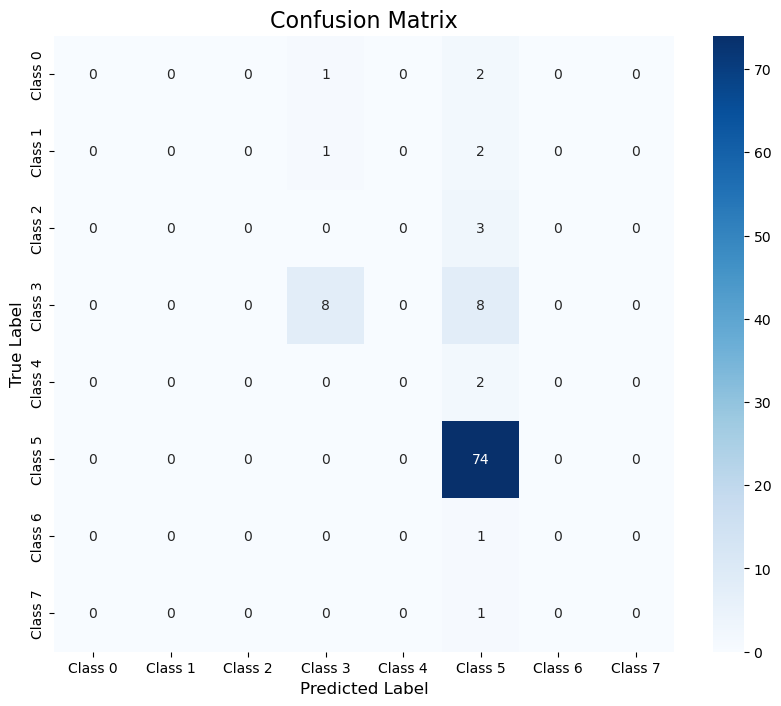

In [ ]:
# 6. Evaluation Metrics
# Classification Report

print("Unique classes in y_test:", np.unique(y))
print("Number of unique classes:", len(np.unique(y)))

num_classes = len(np.unique(y))  # Get the actual number of classes
target_names = [f"Class {i}" for i in range(num_classes)]  # Generate correct labels

print(f"\nAccuracy: {accuracy*100:.2f}%")
print("Classification Report:")
print(classification_report(y, y_pred_mapped, target_names=target_names))


# Confusion Matrix
cm = confusion_matrix(y, y_pred_mapped)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


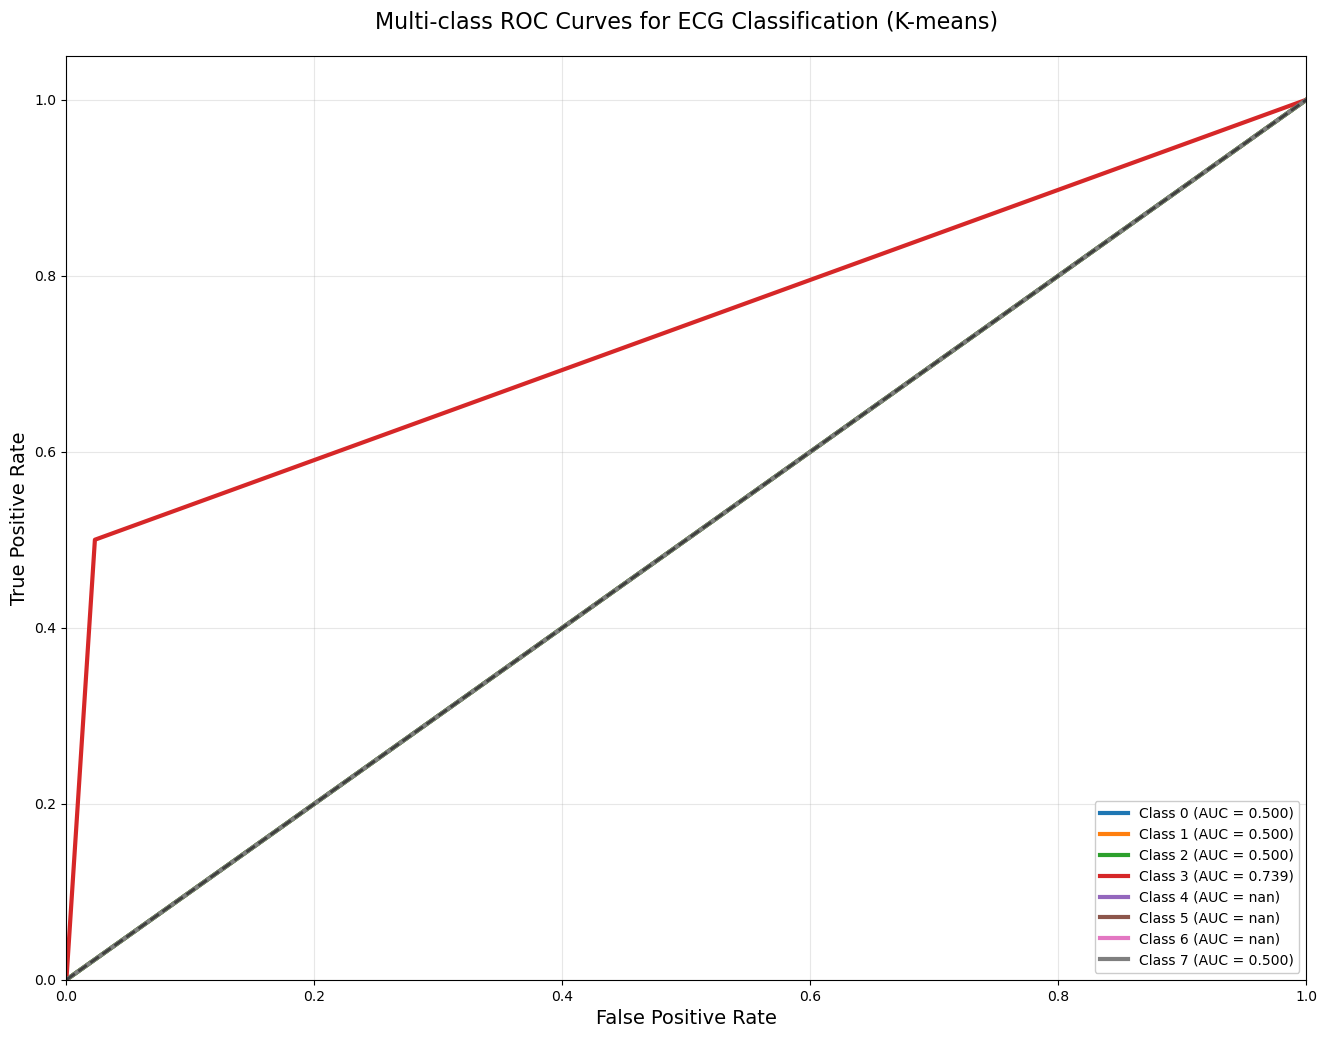

In [ ]:
# 7. ROC Curves for All Classes
# Binarize the true and predicted labels for ROC calculation
y_test_bin = label_binarize(y, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred_mapped, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(16, 12))
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification (K-means)', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1)
plt.grid(alpha=0.3)
plt.show()

KMeans - Balanced Dataset

In [38]:
# 1. Load and prepare data
df = pd.read_csv("../Datasets/Balanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [39]:
df['target'].value_counts()

target
8     367
3     367
13    367
2     367
4     367
5     367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64

In [40]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

In [41]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Preserve class distribution
)

In [42]:
# 3. Feature scaling (essential for K-means)
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [43]:
# 4. Initialize and train KMeans Clustering model
kmeans = KMeans(
    n_clusters=15,        # 15 clusters (assuming 15 classes)
    init='random',     # Smart centroid initialization
    max_iter=300,         # Ensures convergence
    random_state=42,      # Reproducibility
    n_init=10             # Number of times k-means runs with different centroid seeds
)   

In [44]:
# Fit K-means on training data and predict clusters on test data
kmeans.fit(X_train)
y_pred_train = kmeans.predict(X_train)
y_pred_test = kmeans.predict(X_test)

In [35]:
# 5. Map K-means cluster labels to actual class labels
# Since K-means assigns arbitrary cluster labels, we need to map them to true labels
#Using the most frequent true label in each cluster for mapping
def map_clusters_to_labels(y_true, y_cluster):
    y_true = pd.Series(y_true)  # Ensure y_true is a pandas Series
    mapping = {}
    for cluster in np.unique(y_cluster):  # Iterate only over existing clusters
        mask = (y_cluster == cluster)
        if mask.sum() > 0:  # Ensure cluster is not empty
            most_common = y_true[mask].mode().iloc[0]  # Handle multiple modes safely
            mapping[cluster] = most_common
    # Map cluster predictions to true labels
    y_mapped = np.array([mapping.get(cluster, -1) for cluster in y_cluster])
    return y_mapped

# Map clusters to true labels for test set
y_pred_mapped = map_clusters_to_labels(y_test, y_pred_test)

In [36]:
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 66.25%


In [37]:
# 6. Evaluation Metrics
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_mapped, target_names=[f"Class {i}" for i in range(15)]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mapped)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(15)],
            yticklabels=[f"Class {i}" for i in range(15)])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


Classification Report:



ValueError: Number of classes, 14, does not match size of target_names, 15. Try specifying the labels parameter

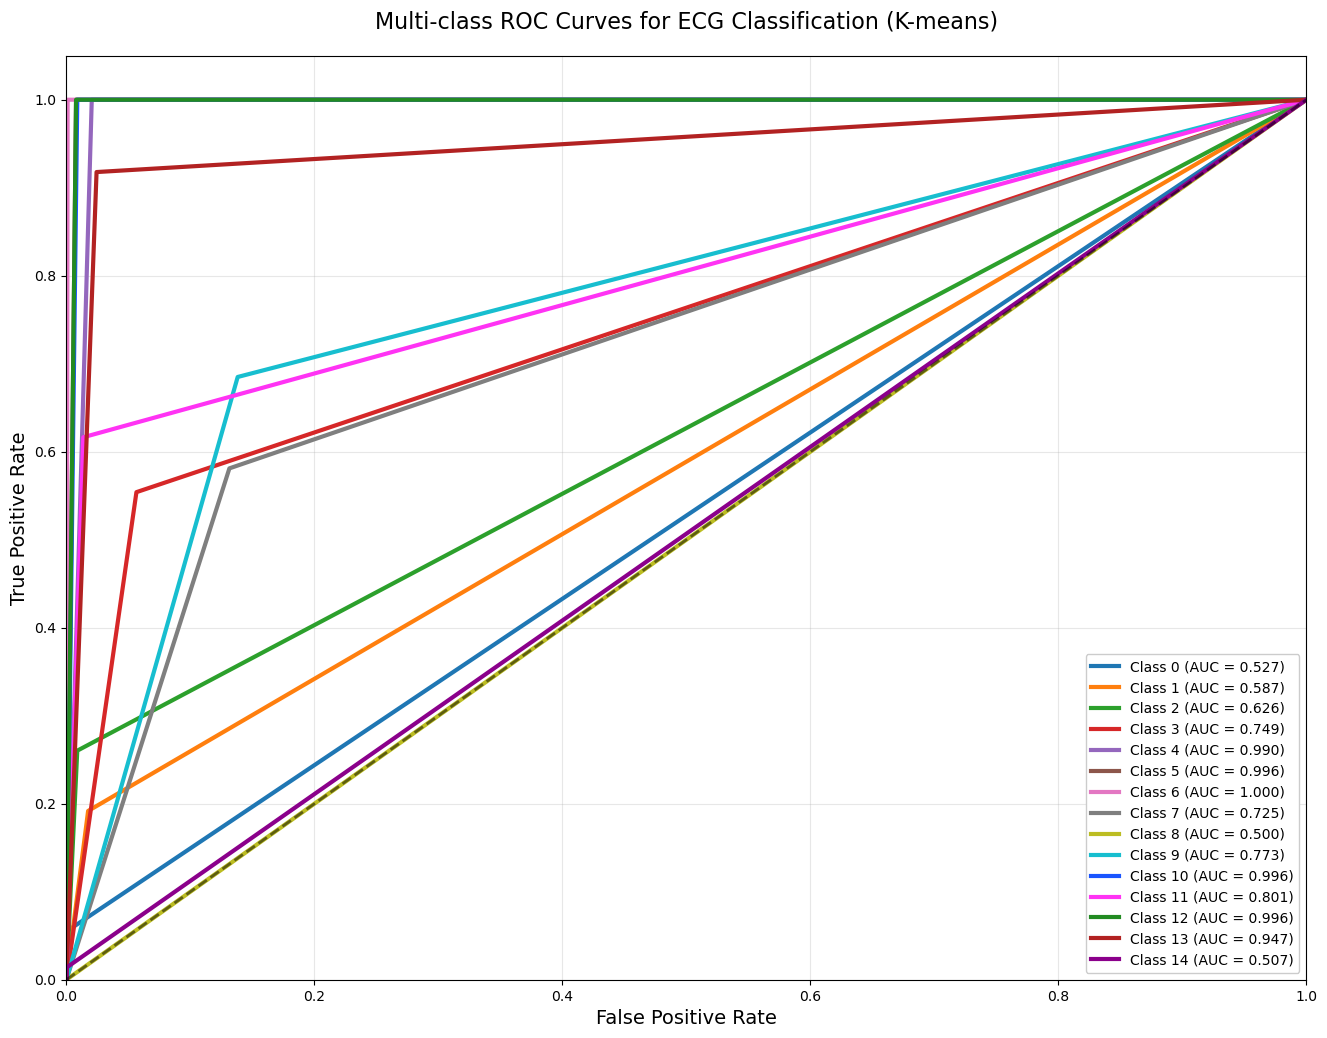

In [211]:
# 7. ROC Curves for All Classes
# Binarize the true and predicted labels for ROC calculation
y_test_bin = label_binarize(y_test, classes=range(15))
y_pred_bin = label_binarize(y_pred_mapped, classes=range(15))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(16, 12))
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

for i, color in zip(range(15), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification (K-means)', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1)
plt.grid(alpha=0.3)
plt.show()